In [1]:
import os, sys
sys.path.append(os.path.abspath(os.path.join('../..'))) # access sibling directories
sys.path.append("C:\\Users\\lasse\\Documents\\GitHub\\BayesFlow")

from src.python.settings import summary_meta_diffusion, evidence_meta_diffusion
from src.python.helpers import load_empirical_rt_data, join_and_fill_missings
from src.python.helpers import inspect_robustness_noise, inspect_robustness_bootstrap, inspect_robustness_lopo
from src.python.networks import HierarchicalInvariantNetwork, EvidentialNetwork
from src.python.visualization import plot_model_posteriors, plot_noise_robustness

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from functools import partial
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.facecolor'] = 'w'

from bayesflow.trainers import ModelComparisonTrainer
from bayesflow.amortizers import MultiModelAmortizer 
from bayesflow.losses import log_loss

In [2]:
# Hack to correctly set facecolor to white
# matplotlib 3.5 only sets facecolor if a plot was already created 
_ = plt.figure()
plt.rcParams['figure.facecolor'] = 'w'

<Figure size 432x288 with 0 Axes>

# Application to empirical data

## Load in data

In [3]:
# Load data from folders

parent_folder = os.path.dirname(os.path.dirname(os.getcwd()))
color_folder = os.path.join(parent_folder, 'data\\03_levy_flight_application\\data_rts\\color')
lexical_folder = os.path.join(parent_folder, 'data\\03_levy_flight_application\\data_rts\\lexical')

color_data = load_empirical_rt_data(color_folder)
lexical_data = load_empirical_rt_data(lexical_folder)

# Join experimental data and fill missing values
empirical_data = join_and_fill_missings(color_data, lexical_data, n_trials=900, missing_rts_equal_mean=True)

## Load in trained network

In [4]:
summary_net = HierarchicalInvariantNetwork(summary_meta_diffusion)
evidence_net = EvidentialNetwork(evidence_meta_diffusion)
amortizer = MultiModelAmortizer(evidence_net, summary_net)

# Checkpoint path for loading pretrained network and saving the final network
trial_folder = 'trial_4'
checkpoint_path = os.path.join(os.getcwd(), 'training_checkpoints', trial_folder)

trainer = ModelComparisonTrainer(
    network=amortizer, 
    loss=partial(log_loss, kl_weight=0),
    optimizer=partial(Adam),
    checkpoint_path=checkpoint_path,
    skip_checks=True
    )

TRAINER INITIALIZATION: No generative model provided. Only offline learning mode is available!
Networks loaded from c:\Users\lasse\Dropbox\Uni Mannheim\M.Sc\4. Semester\Masterarbeit\Coding\notebooks\03_levy_flight_application\training_checkpoints\trial_4\ckpt-64


## Predict

In [5]:
preds = evidence_net.predict(summary_net(empirical_data))
preds

{'m_probs': array([[0.12481197, 0.12581766, 0.53787893, 0.21149142]], dtype=float32),
 'm_var': array([[0.01188062, 0.01196259, 0.02703471, 0.01813763]], dtype=float32),
 'uncertainty': array([[0.48814434]], dtype=float32)}

### Get PMP & BF tables

In [6]:
labels_verbose = ['Basic diffusion model',
          'Basic Lévy flight model',
           'Full diffusion model',
           'Full Lévy flight model']

labels = ['$\mathcal{M}_1$',
          '$\mathcal{M}_2$',
          '$\mathcal{M}_3$',
          '$\mathcal{M}_4$']

In [7]:
# Get posterior model probabilities

pd.DataFrame(preds['m_probs'], index=['Posterior model probability'], columns=labels_verbose)

,Basic diffusion model,Basic Lévy flight model,Full diffusion model,Full Lévy flight model
Posterior model probability,0.124812,0.125818,0.537879,0.211491


In [8]:
# Get Bayes Factors

bfs = []

for model in range(4):
    for model_prob in preds['m_probs']:
        model_bfs = model_prob/preds['m_probs'][0][model]
        bfs.append(model_bfs.round(2))

bf_table = pd.DataFrame(bfs, index=labels_verbose, columns=labels_verbose)
bf_table

,Basic diffusion model,Basic Lévy flight model,Full diffusion model,Full Lévy flight model
Basic diffusion model,1.00,1.01,4.31,1.69
Basic Lévy flight model,0.99,1.00,4.28,1.68
Full diffusion model,0.23,0.23,1.00,0.39
Full Lévy flight model,0.59,0.59,2.54,1.00


In [9]:
# Get Bayes Factors for publication

# Wide format
bf_table_wide = pd.DataFrame(bf_table.iloc[:, 2].values.reshape(1, 4), index=['Bayes Factor'], columns=labels)
bf_table_wide.iloc[0, 2] = '*'
print(bf_table_wide.style.to_latex(position='h', position_float='centering', hrules=True))

\begin{table}[h]
\centering
\begin{tabular}{lrrlr}
\toprule
 & $\mathcal{M}_1$ & $\mathcal{M}_2$ & $\mathcal{M}_3$ & $\mathcal{M}_4$ \\
\midrule
Bayes Factor & 4.310000 & 4.280000 & * & 2.540000 \\
\bottomrule
\end{tabular}
\end{table}



In [10]:
# # Long format
# bf_table_long = pd.DataFrame(bf_table.iloc[:, 2])
# bf_table_long.columns=['Bayes Factor']
# bf_table_long.iloc[2, 0] = '*'
# print(bf_table_long.style.to_latex(position='h', position_float='centering', hrules=True))

### Plot model posteriors

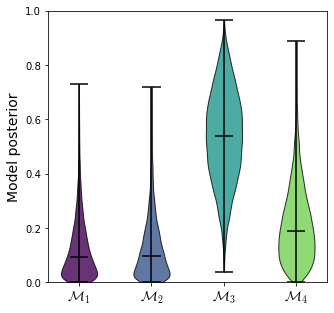

In [11]:
# Get samples from dirichlet distribution
evidences = evidence_net(summary_net(empirical_data))
dirichlet = evidence_net.sample(summary_net(empirical_data),10000)

plot_model_posteriors(dirichlet_samples=dirichlet, labels=labels, save=False)

# Robustness checks

## Additional noise

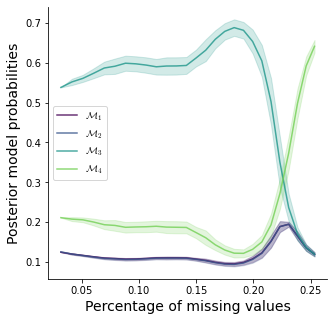

In [12]:
added_noise_percentages = np.arange(0, 0.27, 0.01)
mean_noise_proportion_list, mean_probs, mean_sds, mean_vars = inspect_robustness_noise(added_noise_percentages, 
                                                                                       empirical_data, evidence_net, 
                                                                                       summary_net, n_runs=100)

plot_noise_robustness(mean_noise_proportion_list, mean_probs, mean_sds, labels, save=False)

## Resampled trials within participants

In [13]:
bootstrapped_trials = inspect_robustness_bootstrap(empirical_data, evidence_net, summary_net, level='trials')
bootstrapped_participants = inspect_robustness_bootstrap(empirical_data, evidence_net, summary_net, level='participants')
leave_one_participant_out = inspect_robustness_lopo(empirical_data, evidence_net, summary_net)

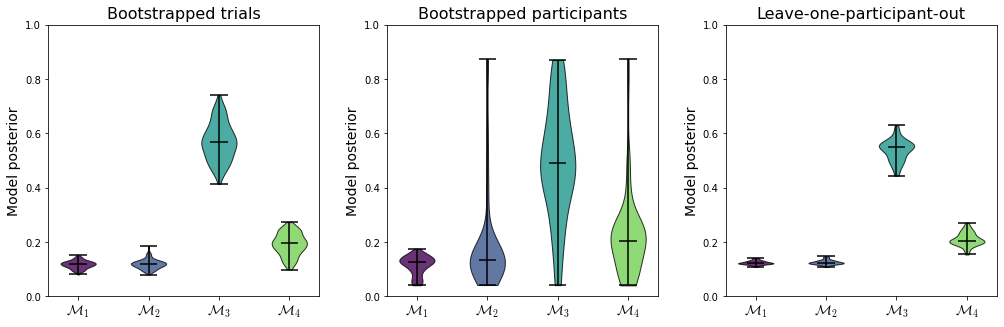

In [14]:
fig, axarr = plt.subplots(1, 3, figsize=(17, 5))
plt.subplots_adjust(wspace=0.25)

plot_model_posteriors(bootstrapped_trials, labels, title='Bootstrapped trials', ax=axarr[0])
plot_model_posteriors(bootstrapped_participants, labels, title='Bootstrapped participants',ax=axarr[1])
plot_model_posteriors(leave_one_participant_out, labels, title='Leave-one-participant-out',ax=axarr[2])

plt.savefig('levy_resampling_robustness.png', dpi=300, bbox_inches='tight')